# Code Sandbox

A place to test new code and functions

In [1]:
# import packages and set working directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp
import seaborn as sns

#os.chdir('../maize-Toff')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import make_climate_parameters, average_soil_moisture

In [2]:
climate = Climate(station='OL JOGI FARM')

soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=180)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)
model.run()
o = model.output() # This is the correct length

In [3]:
planting_date = 100
s0_mean, s0_std = average_soil_moisture(model, n_sims=500, doy=planting_date)
output = model.run(s0=s0_mean, planting_date=planting_date, do_output=True)
#output # This just returns the length of average soil moisture calculation

In [4]:
average_soil_moisture(model, n_sims=1000, doy=90)

(59    0.558419
 dtype: float64, 59    0.076217
 dtype: float64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fc7d160>]],
      dtype=object)

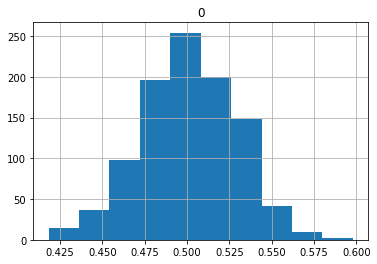

In [5]:
n_sim = 1000
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

planting_date = 10

output = [model.run(do_output=True, planting_date=planting_date) for model in models]

s_avg = pd.DataFrame([o['s'].mean() for o in output])
s_avg.hist()

A few tests related to this figure:

Is the length of the output the same as the length of growing period? True 180


,R,L
21,0.000000,0.0
22,10.986901,0.0
23,0.000000,0.0
24,0.000000,0.0
25,0.000000,0.0
26,0.000000,0.0
27,0.000000,0.0
28,0.000000,0.0
29,1.219861,0.0
30,0.000000,0.0


### 2. Generate figure with 3 LGPs, 2 climatologies

There are slight differences between the two climatologies, but they're there!

Update this figure once code above is sorted.

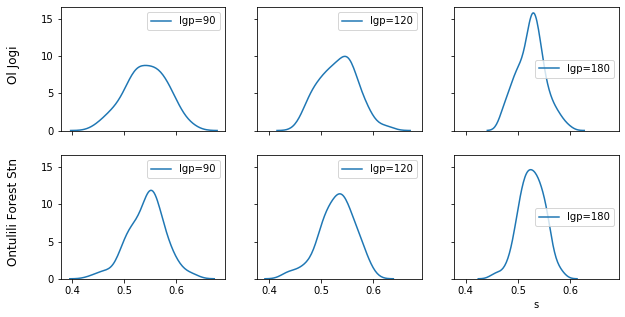

In [30]:
def plot_multiple_pdfs(n_sim = 500, pd_sim = 100, lgp_ic = 180, lgp_early = 90, lgp_med = 120, lgp_late = 180, 
                       start = 21, station_1 = 'OL JOGI FARM', station_2 = 'ONTULILI FOREST STN', texture = 'loam'):

    fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(10, 5), sharex=True, sharey=True)

    # Climatologies
    clims = [(station_1, 0), (station_2, 1)]

    for x,y in clims:
        
        # Part 1. Set conditions for IC runs
        n_sim = n_sim # change back to 1000 later
        planting_date = pd_sim # Because we want a date with little rainfall

        # Part 2. Initialize model with a climate, soil and crop
        climate = Climate(station=x)
        soil = Soil(texture=texture)
        crop = Crop(soil=soil, lgp=lgp_ic)
        soil.set_nZr(crop)

        model = CropModel(crop=crop, climate=climate, soil=soil)
        model.run()
        o = model.output()

        # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
        s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
        models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

        # Part 4. Select the planting date we want. 
        planting_date = pd_sim

        # Part 5: Run the actual simulations (this is where my code deviates from what I wrote in sandbox)
        lgp = lgp_early
        soil = Soil(texture=texture)
        crop = Crop(soil=soil, lgp=lgp)
        soil.set_nZr(crop)
        models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
        output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

        # Part 6. Subset the growing period and get avg, var soil moisture
        start = start
        end = start + lgp

        #avg_df_90 = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
        #avg_df_90["mean"] = avg_df_90.mean(axis=1)  
        #avg_df_90["var"] = avg_df_90.var(axis=1)  
        avg_df_90 = [df[start:end]['s'].mean() for df in output]

        # Part 7. Plot
        sns.distplot(avg_df_90, bins=None, hist=False, kde=True, rug=False, ax=axes[y,0],  label="lgp=%d" %lgp) 
        plt.xlabel('s')

        # Repeat for LGP = 120, 180
        lgps = [(lgp_med, 1), (lgp_late, 2)]

        for a,b in lgps:
            lgp = a
            soil = Soil(texture=texture)
            crop = Crop(soil=soil, lgp=lgp)
            soil.set_nZr(crop)
            models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
            output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]
            end = start + lgp
            avg_df_120 = [df[start:end]['s'].mean() for df in output] 
            sns.distplot(avg_df_120, bins=None, hist=False, kde=True, rug=False, ax=axes[y,b], label="lgp=%d" %lgp) # label="a)" 

    fig.text(0.06, 0.72, 'Ol Jogi', ha='center', va='center', rotation='vertical', fontsize=12)
    fig.text(0.06, 0.31, 'Ontulili Forest Stn', ha='center', va='center', rotation='vertical', fontsize=12)

    #plt.savefig('PD100_OlJogi_Loam.png')
    # next step is to make that table of averagaes I think. 
    
plot_multiple_pdfs()